# Comparison between mock-based + analytic covariance

We compare the analytic calculation of the Gaussian covariance for a survey with a given $\bar{n}$ to the mock-based results for the 84 N-cutsky mocks and the 1000 eBOSS DR14Q EZ mocks. 

See the ``theory.ipynb`` notebook in this directory for the analytic calculation.

**Notes**
- there are 84 N-cutsky mocks
- there are 1000 EZ mocks
- no redshift evolution for N-cutsky mocks
- there is redshift evolution for EZ mocks
- analytic calculation for N-cutsky mocks agrees either when using best-fit model, or P(k,mu) measured from the underlying periodic cubic boxes
- no cubic boxes for EZ mocks so we are using simple Kaiser multipoles with expected $b(z)$ to predict analytic covariance
- analytic calculation appears to over-estimate covariance by a near-constant amount across multiple simulations

In [2]:
from pyRSD.rsdfit.data import PoleCovarianceMatrix
from nbodykit import style
import numpy
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [18]:
def load_cov(sim, kind='mock'):
    """
    Load the covariance matrix from disk.
    """
    if sim == 'ncutsky':
        if kind == 'mock':
            return PoleCovarianceMatrix.from_plaintext('../results/covariance/ncutsky_mock_cov_02.dat')
        else:
            return PoleCovarianceMatrix.from_plaintext('../results/covariance/ncutsky_analytic_cov_from_data_02.dat')
    else:
        sample = sim.split('-')[-1]
        if kind == 'mock':
            return PoleCovarianceMatrix.from_plaintext('../results/covariance/eboss_%s_mock_cov_02.dat' %sample)
        else:
            return PoleCovarianceMatrix.from_plaintext('../results/covariance/eboss_%s_analytic_cov_evolve_02.dat' %sample)

# 1.1 Comparison of $C_{00}$ and $C_{22}$

In [106]:
def renormalize(C, ncells=1):
    X = C.normalized
    N = numpy.diag(X.values).copy()

    for i in range(ncells, ncells+1):
        N[i:] += numpy.diag(X.values, k=i)
        N[:-i] += numpy.diag(X.values, k=-i)
        
    return N

def plot_variance(sim, ells, renorm=False, ncells=1):
    
    C1 = load_cov(sim, 'mock')
    C2 = load_cov(sim, 'analytic')
    
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 1, 2)
    
    for ell1, ell2 in ells:
        a = C1.sel(ell1=ell1, ell2=ell2)
        b = C2.sel(ell1=ell1, ell2=ell2)
        
        if renorm:
            N = renormalize(a, ncells)
        else:
            N = 1

        # plot on log-log scale
        label = r'$\ell_1=%d$, $\ell_2=%d$' %(ell1,ell2)
        ax1.loglog(a.ks(), abs(a.diag), label=label+' (mock)')
        ax1.loglog(b.ks(), abs(b.diag/N), label=label+' (analytic)', c='0.5')
    
        # plot ratio
        ax2.plot(a.ks(), abs(a.diag/b.diag*N), label=label)
        ax2.axhline(y=1, c='k', ls='--')
        
    ax1.legend(ncol=2, fontsize=14, loc=0)
    ax2.legend(fontsize=14, loc=0)
    ax2.set_xlabel(r"$k$ $[h/\mathrm{Mpc}]$")
    ax2.set_ylabel(r"$|C_{%d%d}^\mathrm{mock} / C_{%d%d}^\mathrm{analytic}|$" % tuple([ell1,ell2]*2))
    ax1.set_ylabel(r"$|C_{%d%d}| \; [h^{-3}\mathrm{Mpc}^3]^2$" %(ell1,ell2))
    return ax1, ax2

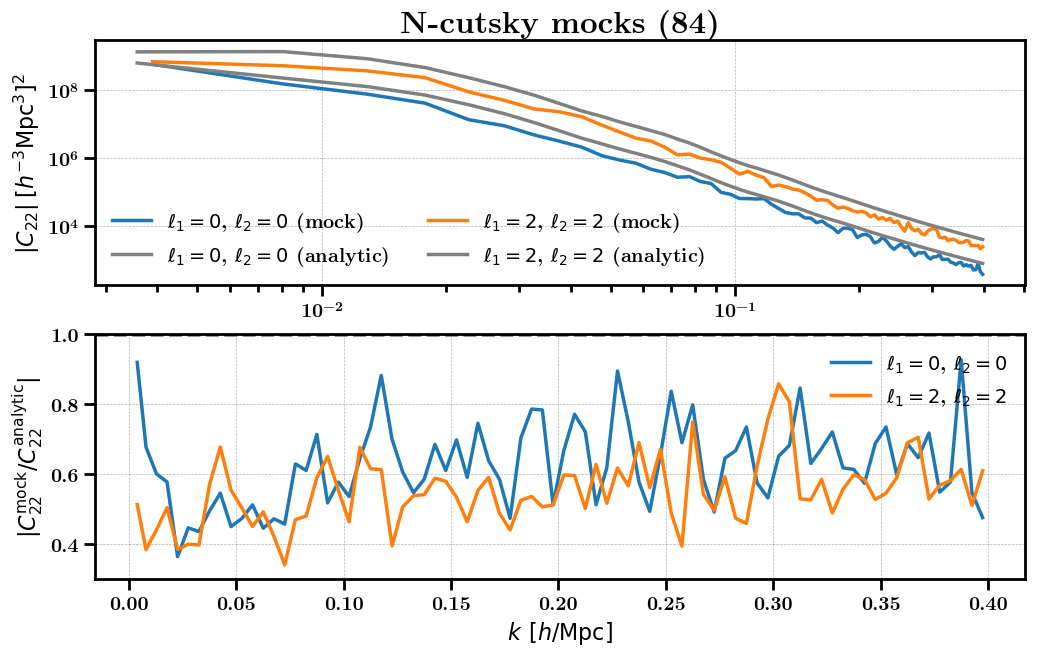

In [101]:
ax1, ax2 = plot_variance('ncutsky', [(0,0), (2,2)])
ax2.set_ylim(0.3, 1.0)
ax1.set_title("N-cutsky mocks (84)")
plt.show()

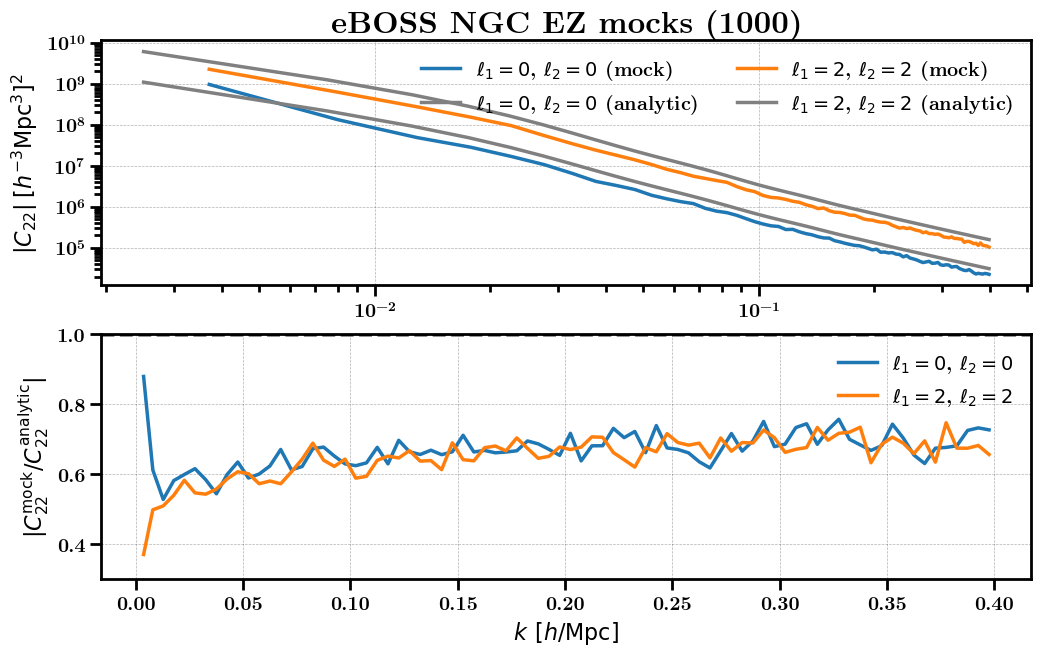

In [86]:
ax1, ax2 = plot_variance('eboss-N', [(0,0),(2,2)])
ax2.set_ylim(0.3, 1.0)
ax1.set_title("eBOSS NGC EZ mocks (1000)")
plt.show()

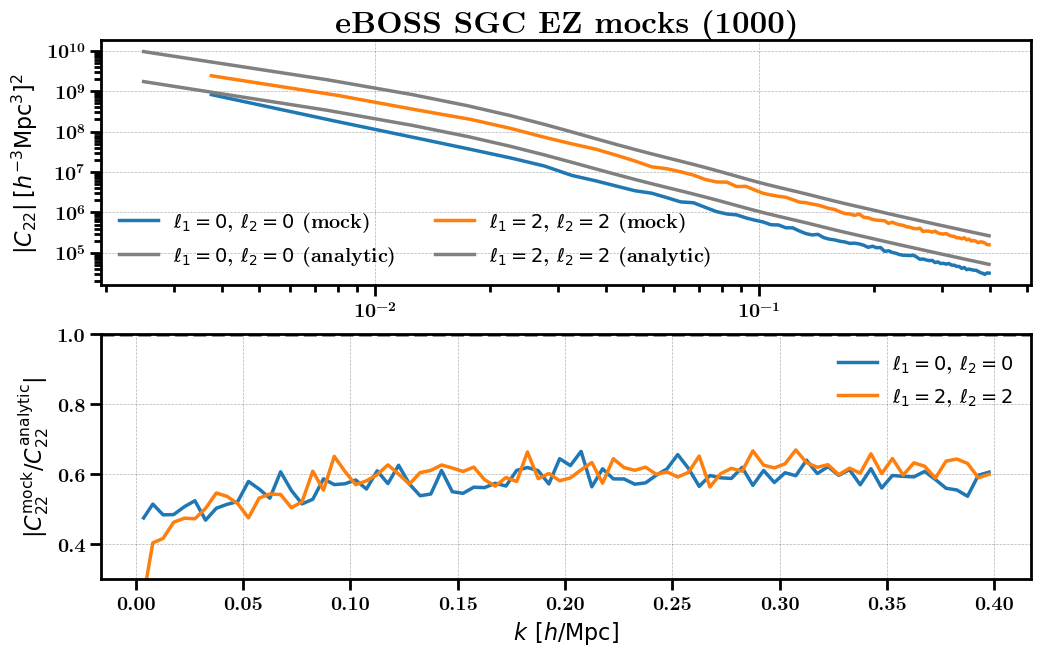

In [88]:
ax1, ax2 = plot_variance('eboss-S', [(0,0), (2,2)])
ax2.set_ylim(0.3, 1.0)
ax1.set_title("eBOSS SGC EZ mocks (1000)")
plt.show()

# 1.2 Comparison of $C_{02}$

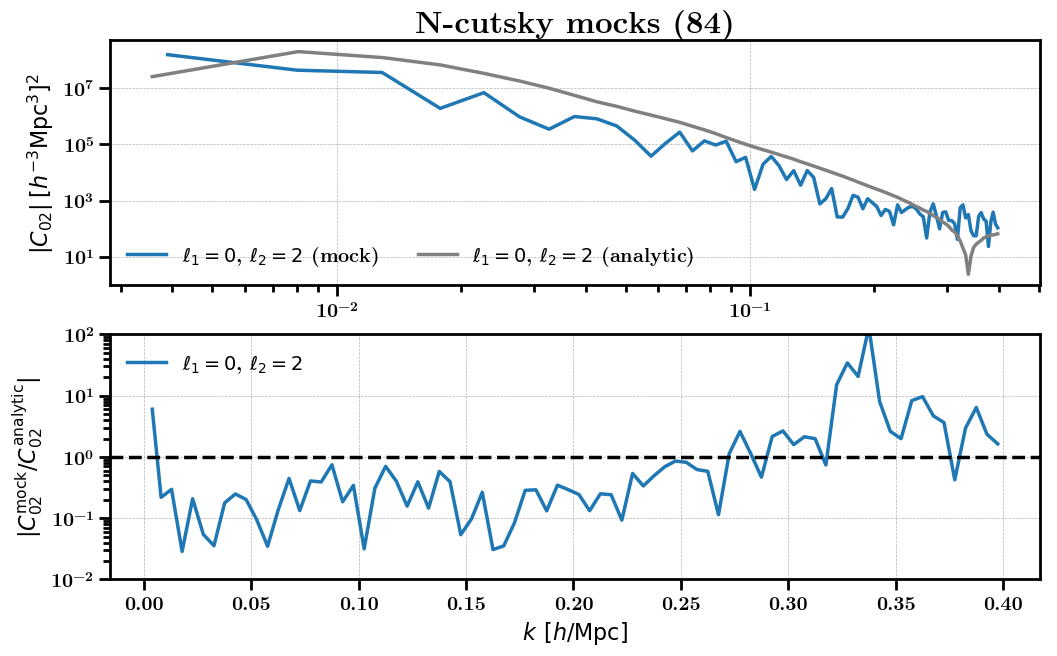

In [89]:
ax1, ax2 = plot_variance('ncutsky', [(0, 2)])
ax2.set_ylim(1e-2, 100)
ax2.set_yscale('log')
ax1.set_title("N-cutsky mocks (84)")
plt.show()

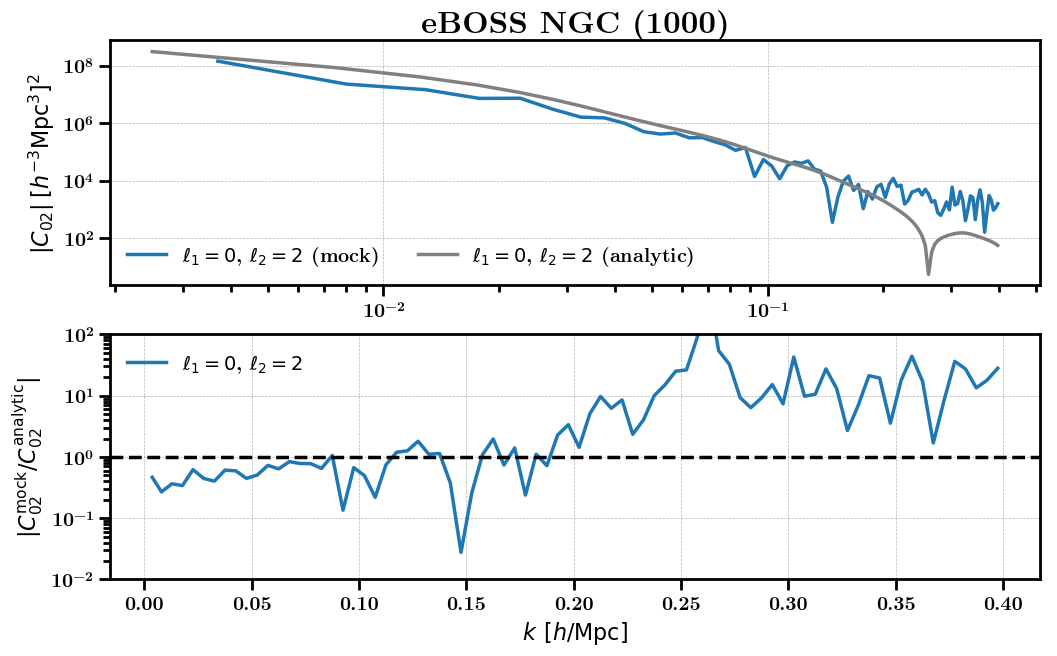

In [177]:
ax1, ax2 = plot_variance('eboss-N', [(0, 2)])
ax2.set_ylim(1e-2, 100)
ax2.set_yscale('log')
ax1.set_title("eBOSS NGC (1000)")
plt.show()

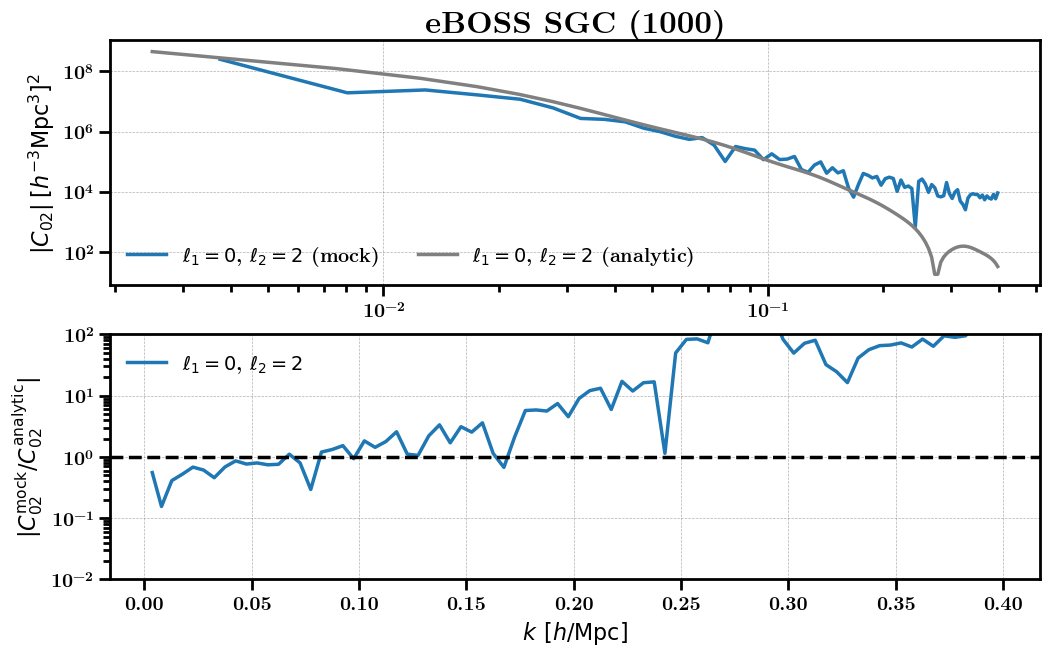

In [91]:
ax1, ax2 = plot_variance('eboss-S', [(0, 2)])
ax2.set_ylim(1e-2, 100)
ax2.set_yscale('log')
ax1.set_title("eBOSS SGC (1000)")
plt.show()

# 2.1 Re-normalized Analytic Calculations 

Here, we re-normalize the analytic variance for bin $k = k_i$ using a correlation width of one bin:

$$
C_{i,i}' = \frac{C_{i,i}}{\widehat{C}_{i,i} + \widehat{C}_{i,i+1} + \widehat{C}_{i,i-1}}
$$,
where $\widehat{C}$ is the correlation matrix (normalized by variance, i.e., unity on diagonals).

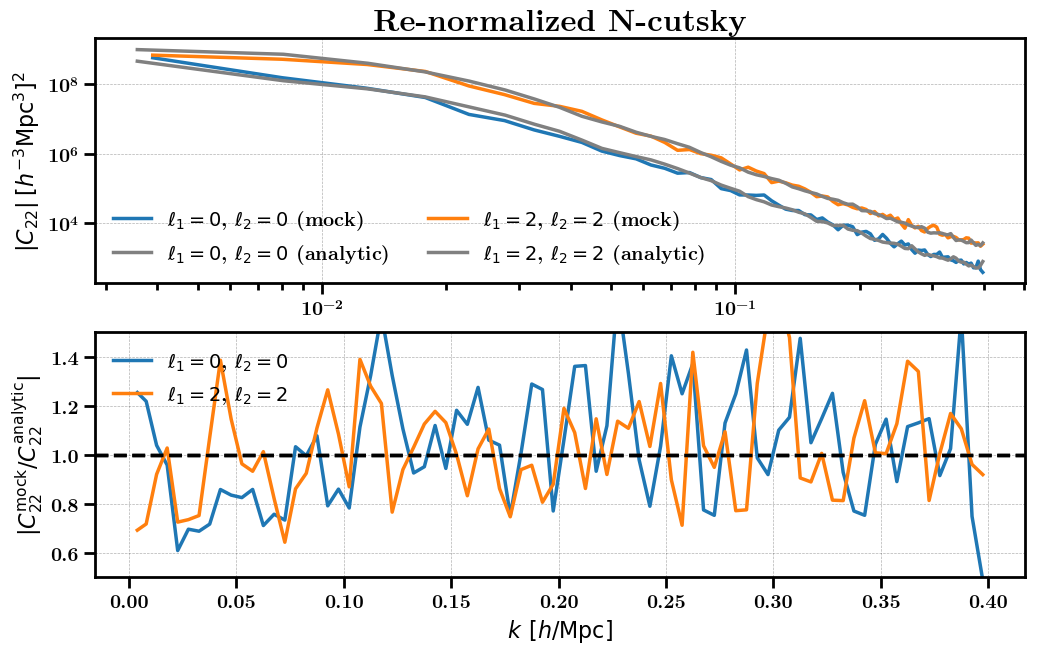

In [116]:
ax1, ax2 = plot_variance('ncutsky', [(0,0), (2,2)], renorm=True)
ax2.set_ylim(0.5, 1.5)
ax1.set_title("Re-normalized N-cutsky")
plt.show()

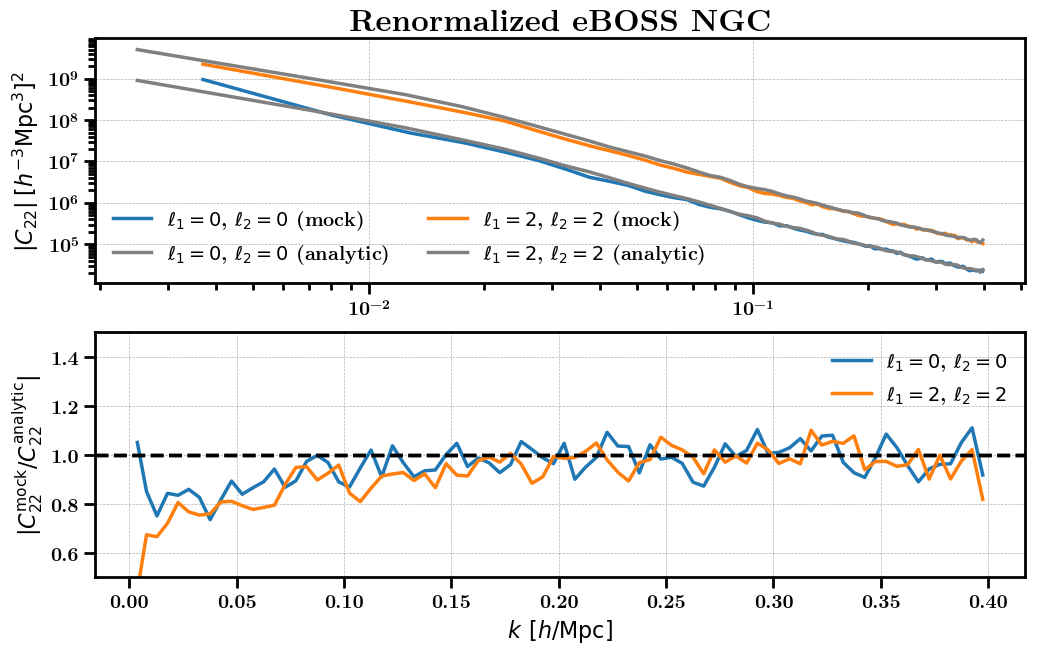

In [115]:
ax1, ax2 = plot_variance('eboss-N', [(0,0),(2,2)], renorm=True)
ax2.set_ylim(0.5, 1.5)
ax1.set_title("Renormalized eBOSS NGC")
plt.show()

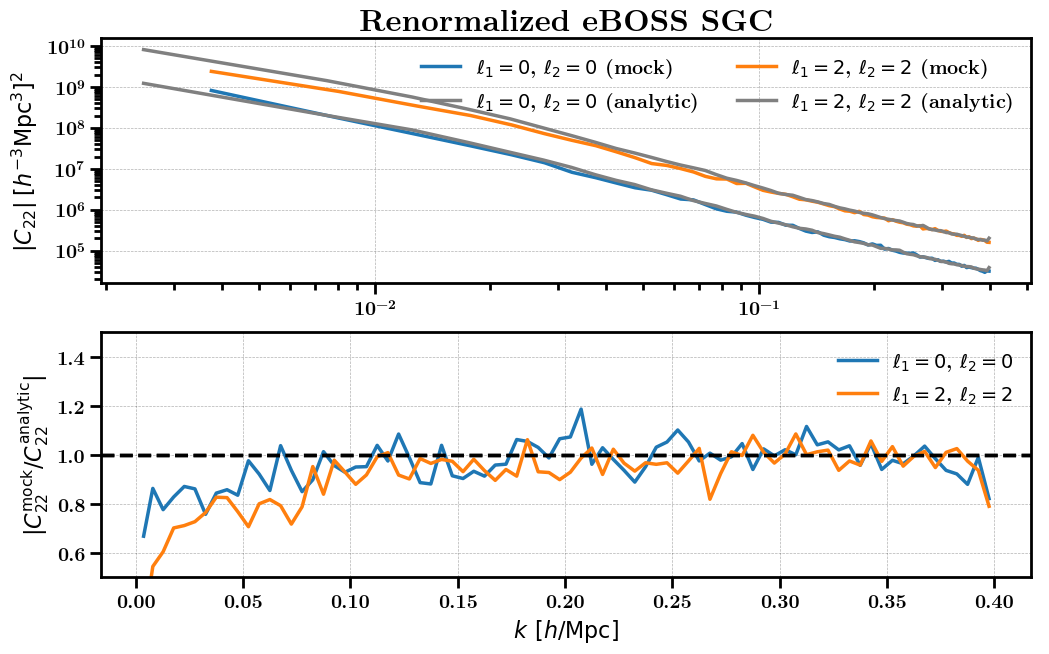

In [114]:
ax1, ax2 = plot_variance('eboss-S', [(0,0),(2,2)], renorm=True)
ax2.set_ylim(0.5, 1.5)
ax1.set_title("Renormalized eBOSS SGC")
plt.show()

# 3.1 Correlation Lengths across Bins

In [171]:
def plot_dispersion(sim, ells, inputk, width=5):
    
    colors = ['#1f77b4', '#ff7f0e']
    C0 = load_cov(sim, 'mock').normalized
    
    for iell, ell in enumerate(ells):
        for i, ki in enumerate(inputk):
            label = r'$\ell_1=\ell_2=%d$' %ell if i == 0 else ""
        
            C = C0.sel(ell1=ell, ell2=ell)
            ks = C.ks()

            # select specific k row
            C = numpy.squeeze(C.sel(k1=ki))
            index = numpy.where(C == 1.0)[0][0]

            # slice
            lo = max(index-width, 0)
            hi = min(index+width+1, len(ks)-1)
            y = C[lo:hi]
            x = ks[lo:hi]

            # plot
            plt.plot(x, y, label=label, c=colors[iell])
    
    plt.legend(loc=0)
    plt.xlabel(r"$k_i$ $[h/\mathrm{Mpc}]$", fontsize=16)
    plt.ylabel("correlation matrix at $k_i$, $k_j$", fontsize=16)
    
    return plt.gca()
            

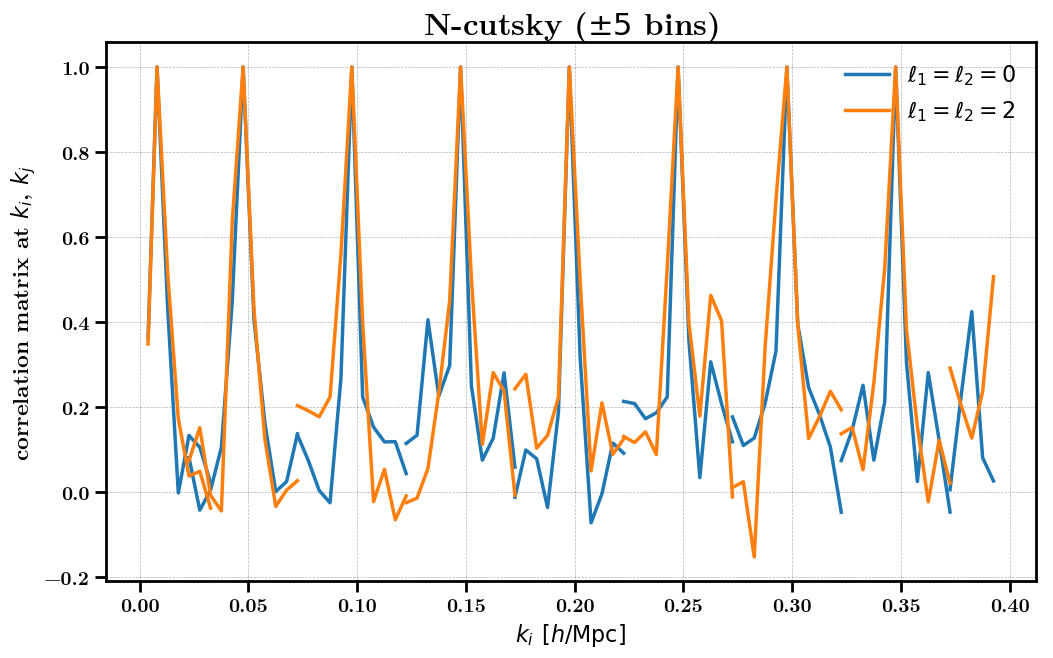

In [179]:
ks = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
ax = plot_dispersion('ncutsky', [0,2], ks)
plt.title(r'N-cutsky ($\pm 5$ bins)')
plt.show()

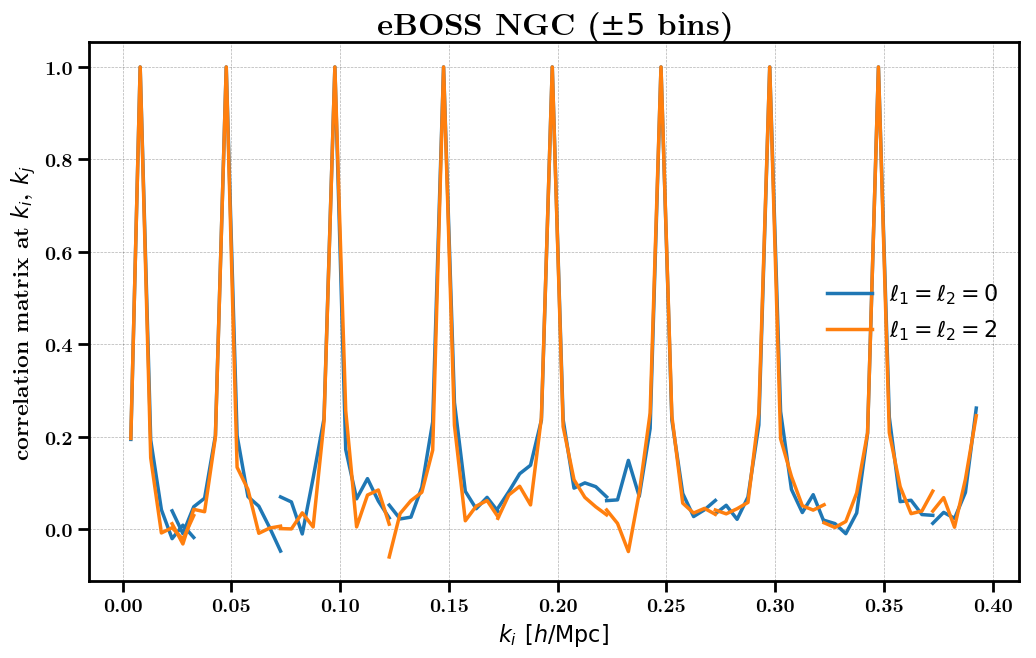

In [180]:
ks = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
ax = plot_dispersion('eboss-N', [0,2], ks)
plt.title('eBOSS NGC ($\pm 5$ bins)')
plt.show()

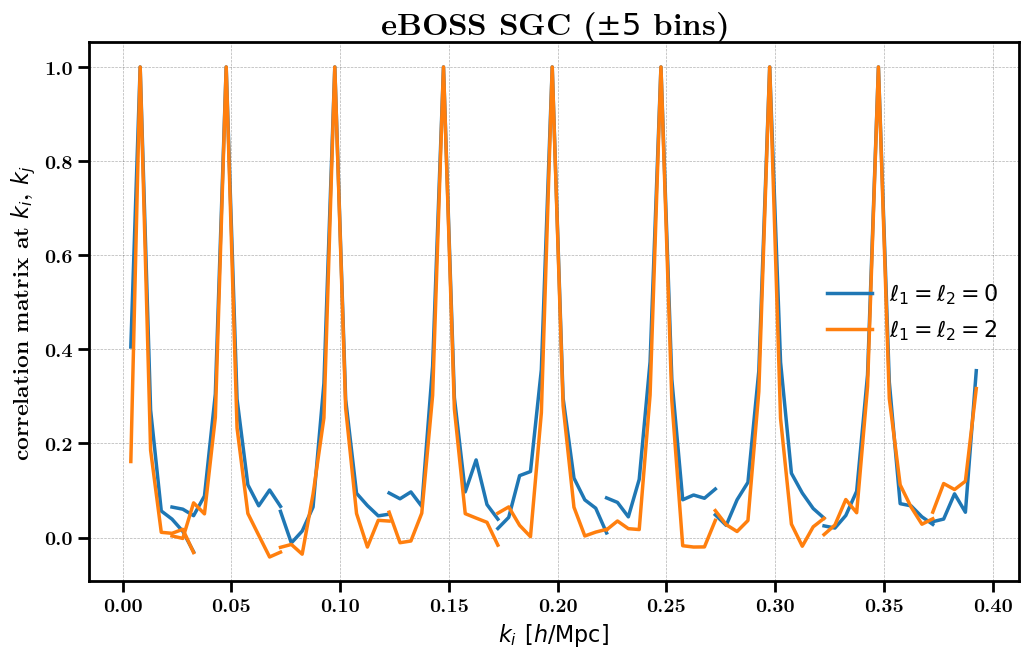

In [181]:
ks = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
ax = plot_dispersion('eboss-S', [0,2], ks)
plt.title('eBOSS SGC ($\pm 5$ bins)')
plt.show()